In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import sys
import csv
import time

data = pd.read_csv("data_OptiMinds.csv")  
print(data.head())

          Time         SN
0  1754.986393   9.225870
1  1754.989171   5.921549
2  1754.991949   8.049531
3  1754.994726  14.136753
4  1754.997504   4.260318


In [2]:

# Convert fractional years to datetime to understand the data better
def fractional_year_to_date(year):
    year_int = int(year)
    remainder = year - year_int
    start_of_year = datetime.datetime(year_int, 1, 1)
    days_in_year = (datetime.datetime(year_int + 1, 1, 1) - start_of_year).days
    return start_of_year + datetime.timedelta(days=remainder * days_in_year)

# Apply conversion
data['Date'] = data['Time'].apply(fractional_year_to_date)

# Drop the original 'Time' column if not needed
data.drop(columns=['Time'], inplace=True)

print(data.head())

          SN                       Date
0   9.225870 1754-12-27 00:48:16.925537
1   5.921549 1754-12-28 01:08:16.170824
2   8.049531 1754-12-29 01:28:15.416110
3  14.136753 1754-12-30 01:48:14.661411
4   4.260318 1754-12-31 02:08:13.906698


--> Data collected every 20 min from 27th December 1754. 

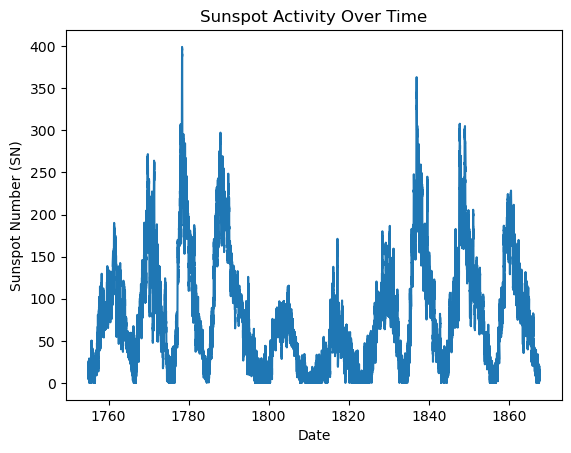

In [3]:
plt.plot(data['Date'], data['SN'])
plt.xlabel("Date")
plt.ylabel("Sunspot Number (SN)")
plt.title("Sunspot Activity Over Time")
plt.show()


### Get the small subset to test functions locally

In [4]:
subset_random = data.sample(n=1000, random_state=42)
print(subset_random.head())

               SN                       Date
3318    61.059679 1764-03-15 06:58:50.319951
32638   43.003447 1845-08-25 01:17:44.775877
27227   82.596295 1830-08-13 22:45:48.499199
24615    0.000000 1823-05-12 16:38:39.795686
29045  132.597282 1835-09-01 04:22:56.440623


### Simulated Annealing

In [23]:
T0 = subset_random['Date'].values
x0 = subset_random['SN'].values

x0= 1.2

# ---- Construct covariance matrix ---- #
n_dims = 2                  # number of dimensions
means = np.full(n_dims, 0)  # array of mean values = [0,0,...,0]
sigma = 1                   # variance (the same for all dimensions)
covariance_matrix = np.diag(np.full(n_dims, sigma))  # diagonal covariance matrix (sigma*I)

# ---- Sample from distribution ---- #
z = np.random.multivariate_normal(means, covariance_matrix)


In [24]:
def simulated_annealing(x0, T0, sigma, f, n_iter = 2.5e5, burn_in = 2e5):
    x = x0.copy()  # initialize x
    T = T0         # initialize T
    n_params = x0.shape[0]  # number of parameters to be optimized

    # Means and covariance matrix for the jump distribution -> multivariate normal with mean 0 and standard deviation sigma
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Size of the output array after burn_in
    size_out = int(n_iter - burn_in)
    v = np.zeros((size_out, n_params))

    iter_counter = 0
    print("Initial loss:", f(x))
    # Start main loop
    while iter_counter < n_iter:
        iter_counter += 1
        x_old = x
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)
        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE/T, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        # Update temperature according to schedule
        T = T0*(1 - iter_counter/n_iter)
        # Keep track of the algorithm state
        if iter_counter % 10000 == 0:
            print("Iteration ", iter_counter, "- Temperature:", T, "Loss:", f(x))
        if iter_counter > burn_in:
            v[iter_counter - int(burn_in) - 1] = x

    return v


def mse(x):
    return np.mean((x - np.mean(x))**2)


# Loss function
outSA = simulated_annealing(x0, T0, sigma, mse, n_iter=2.5e5, burn_in = 2e5)


# Plot the results
plt.plot.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block=False)

AttributeError: 'float' object has no attribute 'copy'